
# Epilepsy Signal Detection Using AI/ML Algorithms

**Importing Libraries & Models**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pickle
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from skimage import io, transform
from sklearn.feature_selection import SelectKBest

**Data Explorartion & Pre-processing**

                X1           X2           X3           X4           X5  \
count  7904.000000  7904.000000  7904.000000  7904.000000  7904.000000   
mean    -12.383477   -11.714954   -11.163841   -10.414474    -9.554782   
std     168.489412   167.972546   164.574004   161.364484   160.336364   
min   -1839.000000 -1838.000000 -1835.000000 -1687.000000 -1755.000000   
25%     -55.000000   -56.000000   -56.000000   -55.000000   -54.000000   
50%      -8.500000    -8.000000    -8.000000    -8.000000    -8.000000   
75%      35.000000    35.250000    36.000000    36.000000    35.000000   
max    1310.000000  1356.000000  1274.000000  1167.000000  1244.000000   

                X6           X7           X8           X9          X10  ...  \
count  7904.000000  7904.000000  7904.000000  7904.000000  7904.000000  ...   
mean     -8.552379    -7.916371    -7.658148    -7.241017    -6.581478  ...   
std     160.684805   161.183542   161.937174   161.028420   158.491153  ...   
min   -1757.00000

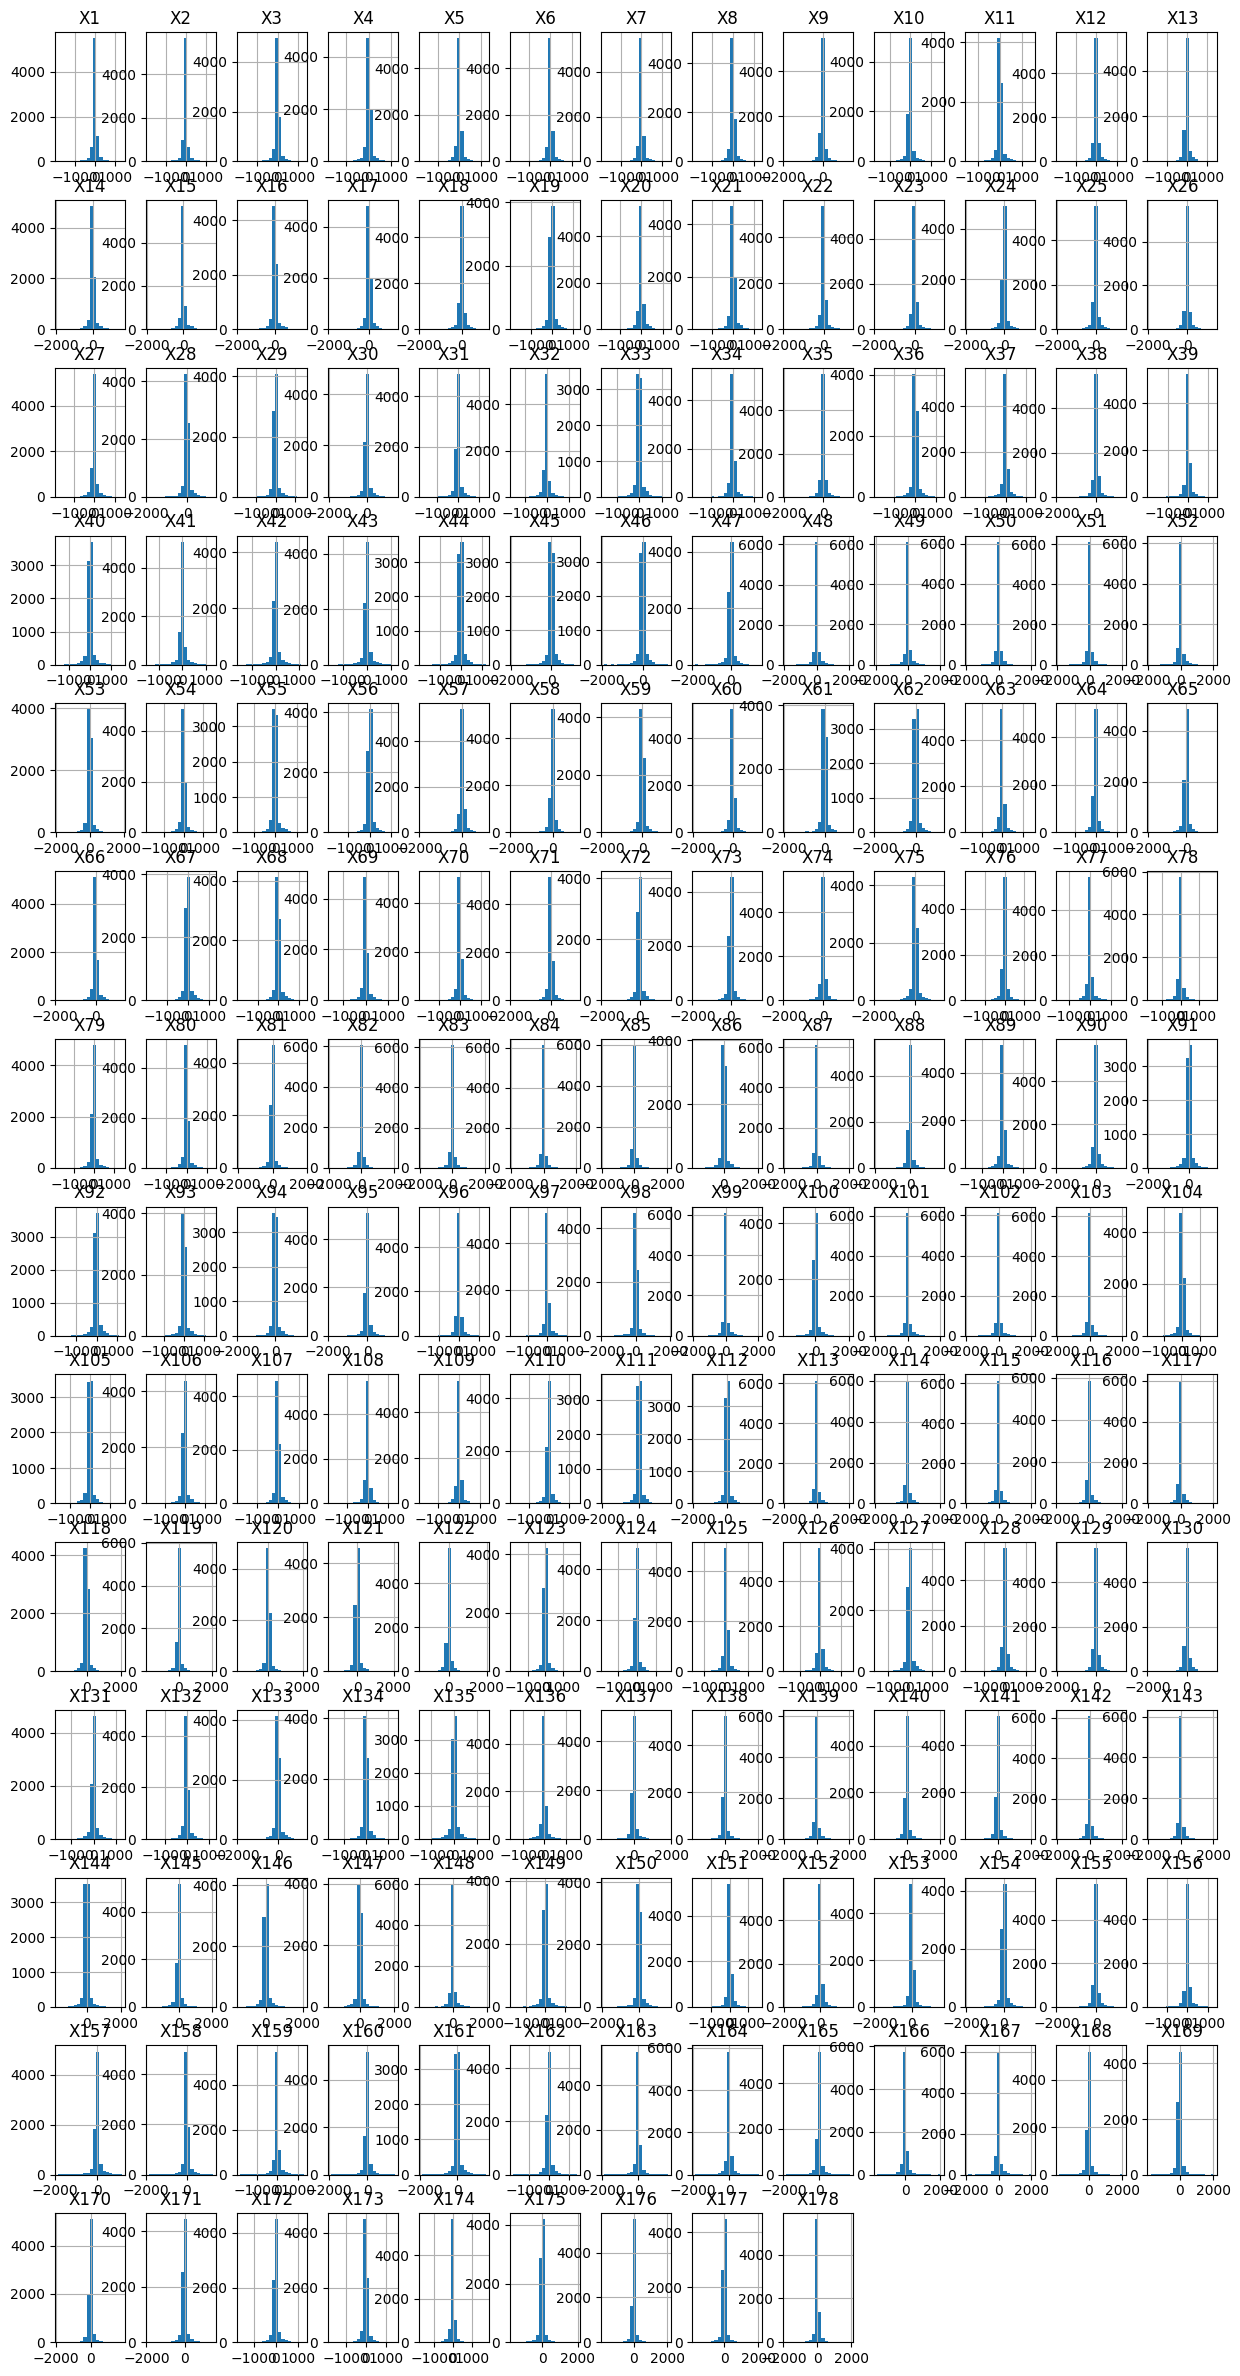

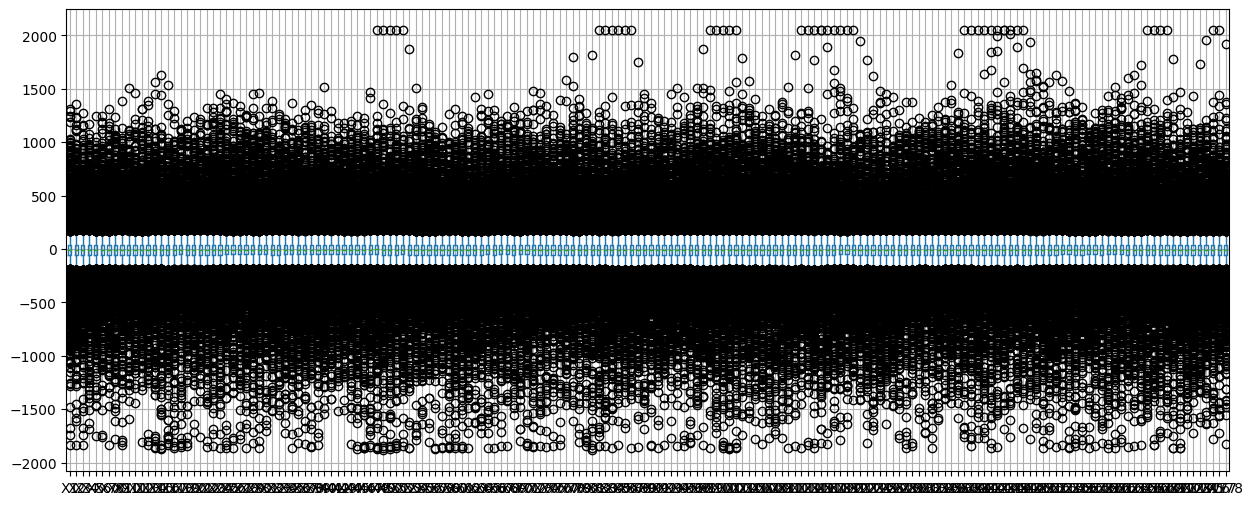

Signals    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       1
X176       1
X177       1
X178       1
y          1
Length: 180, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Columns: 180 entries, Signals to y
dtypes: float64(125), int64(54), object(1)
memory usage: 10.9+ MB
None


In [ ]:
# Load the data into a Pandas DataFrame
data = pd.read_csv('eeg_data.csv')

# Data Exploration - Summary Statistics
summary_stats = data.describe()
print(summary_stats)

# Data Exploration - Visualization
# Histograms for numerical features (signals)
data.iloc[:, 1:-1].hist(figsize=(15, 30), bins=20)  # Excluding the 'Signals' and 'y' columns
plt.show()

# Box plots for numerical features (signals)
data.iloc[:, 1:-1].boxplot(figsize=(15, 6))  # Excluding the 'Signals' and 'y' columns
plt.show()

# Data Exploration - Handling Missing Values
missing_values = data.isnull().sum()
print(missing_values)

# Data Exploration - Data Profiling
data_profile = data.info()
print(data_profile)

# Data Preprocessing - Handling Missing Values
data.dropna(inplace=True)

# Data Preprocessing - Removing Duplicates
data.drop_duplicates(inplace=True)

# Further Data Analysis and Preprocessing
# The data is now clean and ready for further analysis or model training.

# Extract Features and Target Variable
X = data.iloc[:, 1:-1]  # Extract all columns except 'Signals' and 'y' as features
y = data['y']  # Extract the 'y' column as the target variable

# Separate the 'Signals' column to use it as an index
data.set_index('Signals', inplace=True)

# Transpose the DataFrame so that signals are in rows and data values are in columns
data = data.T

**Distinguish Between Epilepsy & Non-Epilepsy Signals**

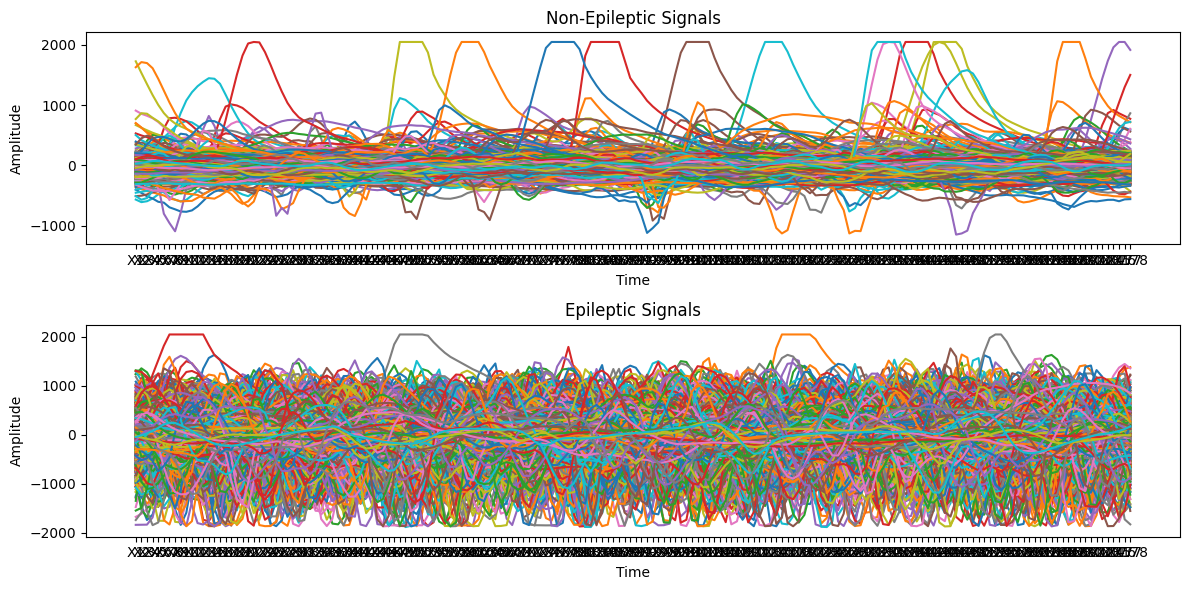

In [ ]:
# Load the Excel sheet
data = pd.read_csv('eeg_data.csv')

# Separate the non-epileptic and epileptic signals based on the 'y' column
non_epileptic_data = data[data['y'] != 1]
epileptic_data = data[data['y'] == 1]

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot non-epileptic signals
for i in range(len(non_epileptic_data)):
    signal_values = non_epileptic_data.iloc[i, 1:-1]
    ax1.plot(signal_values)

# Set labels and title for the non-epileptic plot
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.set_title('Non-Epileptic Signals')

# Plot epileptic signals
for i in range(len(epileptic_data)):
    signal_values = epileptic_data.iloc[i, 1:-1]
    ax2.plot(signal_values)

# Set labels and title for the epileptic plot
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.set_title('Epileptic Signals')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


**Epileptic VS Non-Epileptic Signal Classification: Model Training and Evaluation**

In [ ]:
# Step 1: Load the data into a Pandas DataFrame
data = pd.read_csv('eeg_data.csv')

# Step 2: Extract Features and Target Variable
X = data.iloc[:, 1:-1]  # Extract all columns except 'Signals' and 'y' as features
y = data['y']  # Extract the 'y' column as the target variable

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Separate non-epileptic and epileptic signals based on the target variable
non_epileptic_train = X_train[y_train != 1]
non_epileptic_test = X_test[y_test != 1]

epileptic_train = X_train[y_train == 1]
epileptic_test = X_test[y_test == 1]

# Step 5: Perform feature selection
k = 50  # Number of top features to select
selector = SelectKBest(score_func=lambda X, y: chi2(X, y), k=k)

# Train the model for non-epileptic signals
non_epileptic_selector = selector.fit(non_epileptic_train.abs(), y_train[y_train != 1])
non_epileptic_train_selected = non_epileptic_selector.transform(non_epileptic_train)
non_epileptic_test_selected = non_epileptic_selector.transform(non_epileptic_test)

non_epileptic_model = RandomForestClassifier(n_estimators=100, random_state=42)
non_epileptic_model.fit(non_epileptic_train_selected, y_train[y_train != 1])

# Train the model for epileptic signals
epileptic_selector = selector.fit(epileptic_train.abs(), y_train[y_train == 1])
epileptic_train_selected = epileptic_selector.transform(epileptic_train)
epileptic_test_selected = epileptic_selector.transform(epileptic_test)

epileptic_model = RandomForestClassifier(n_estimators=100, random_state=42)
epileptic_model.fit(epileptic_train_selected, y_train[y_train == 1])

# Step 6: Make predictions on the test set for both models
non_epileptic_pred = non_epileptic_model.predict(non_epileptic_test_selected)
epileptic_pred = epileptic_model.predict(epileptic_test_selected)

# Step 7: Evaluate the models
non_epileptic_accuracy = accuracy_score(y_test[y_test != 1], non_epileptic_pred)
epileptic_accuracy = accuracy_score(y_test[y_test == 1], epileptic_pred)

non_epileptic_conf_matrix = confusion_matrix(y_test[y_test != 1], non_epileptic_pred)
epileptic_conf_matrix = confusion_matrix(y_test[y_test == 1], epileptic_pred)

non_epileptic_report = classification_report(y_test[y_test != 1], non_epileptic_pred)
epileptic_report = classification_report(y_test[y_test == 1], epileptic_pred)

# Step 8: Print the evaluation results for both models
print("Non-Epileptic Model Accuracy:", non_epileptic_accuracy)
print("Non-Epileptic Model Confusion Matrix:\n", non_epileptic_conf_matrix)
print("Non-Epileptic Model Classification Report:\n", non_epileptic_report)

print("Epileptic Model Accuracy:", epileptic_accuracy)
print("Epileptic Model Confusion Matrix:\n", epileptic_conf_matrix)
print("Epileptic Model Classification Report:\n", epileptic_report)


Non-Epileptic Model Accuracy: 0.5623978201634877
Non-Epileptic Model Confusion Matrix:
 [[231 132  35  61]
 [132 228  25  65]
 [ 12  16 314 115]
 [ 55  71  84 259]]
Non-Epileptic Model Classification Report:
               precision    recall  f1-score   support

           2       0.54      0.50      0.52       459
           3       0.51      0.51      0.51       450
           4       0.69      0.69      0.69       457
           5       0.52      0.55      0.53       469

    accuracy                           0.56      1835
   macro avg       0.56      0.56      0.56      1835
weighted avg       0.56      0.56      0.56      1835

Epileptic Model Accuracy: 1.0
Epileptic Model Confusion Matrix:
 [[465]]
Epileptic Model Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       465

    accuracy                           1.00       465
   macro avg       1.00      1.00      1.00       465
weighted avg       1.00  

**Building Epileptic and Non-Epileptic Signal Classification Models and Saving Trained Models for Future Use**

In [ ]:
# Step 9: Save the models to files
joblib.dump(non_epileptic_model, 'non_epileptic_model.joblib')
joblib.dump(epileptic_model, 'epileptic_model.joblib')

# Step 1: Train the feature selector
k = 50  # Number of top features to select
def custom_chi2(X, y):
    return chi2(X, y)[0]

selector = SelectKBest(score_func=custom_chi2, k=k)
# Train the selector using your data
# ...

# Step 2: Save the trained feature selector model
joblib.dump(selector, 'feature_selector.joblib')
print("Feature selector model saved successfully!")

print("Models saved successfully!")


Feature selector model saved successfully!
Models saved successfully!


In [ ]:
# Step 10: Load the models from files
loaded_non_epileptic_model = joblib.load('non_epileptic_model.joblib')
loaded_epileptic_model = joblib.load('epileptic_model.joblib')

# Step 11: Make predictions using the loaded models
non_epileptic_pred = loaded_non_epileptic_model.predict(non_epileptic_test_selected)
epileptic_pred = loaded_epileptic_model.predict(epileptic_test_selected)

# Load the trained feature selector model
feature_selector = joblib.load('feature_selector.joblib')
print("Feature selector model loaded successfully!")


Feature selector model loaded successfully!


In [ ]:
# Assuming you have training data stored in 'training_data' (replace this with your actual training data)
training_data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]  # Replace this with your actual training data (a list of lists)

# Convert the training data to a pandas DataFrame
df = pd.DataFrame(training_data)

# Step 1: Define and fit the MinMaxScaler on your training data
scaler = MinMaxScaler()
scaler.fit(df)

# Step 2: Save the scaler to a file
scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)

# Now you can load the scaler using joblib.load() in your later code:
# scaler = joblib.load('scaler.joblib')


['scaler.joblib']

**Epilepsy Detection Using Trained Models on New EEG Signal Data**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Load and preprocess the image
image_path = 'new_data.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=3)[0]
print('Top predictions:')
for pred in decoded_predictions:
    print(f'{pred[1]}: {pred[2]*100:.2f}%')

# Make predictions on the image
prediction = model.predict(img_array)
predicted_class = 'Epilepsy' if prediction[0][0] > 0.5 else 'Non-Epilepsy'

print('Predicted Class:', predicted_class)

1/1 [==============================] - 1s 767ms/step
Top predictions:
rule: 11.59%
ballpoint: 7.57%
envelope: 7.07%
1/1 [==============================] - 1s 590ms/step
Predicted Class: Non-Epilepsy


**Prediction on Splitted New Samples**

In [ ]:
# Load and preprocess the image
image_path = 'Sample_1.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using your models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')

# After all checks
print('DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am')


1/1 [==============================] - 1s 1s/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am
DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 6am to 8am


In [ ]:
# Load and preprocess the image
image_path = 'Sample_2.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using your models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 8am to 10am')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 8am to 10am')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 8am to 10am')

# After all checks
print('DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 8am to 10am')


1/1 [==============================] - 1s 967ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 8am to 10am
DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 8am to 10am


In [ ]:
# Load and preprocess the image
image_path = 'Sample_3.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using your models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12pm')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12pm')

# After all checks
print('DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12pm')


1/1 [==============================] - 1s 745ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12pm
DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 10am to 12pm


In [ ]:
# Load and preprocess the image
image_path = 'Sample_4.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using your models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 12pm to 02pm')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 12pm to 02pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 12pm to 02pm')

# After all checks
print('DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 12pm to 02pm')


1/1 [==============================] - 1s 803ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 12pm to 02pm
DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 12pm to 02pm


In [ ]:
# Load and preprocess the image
image_path = 'Sample_5.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using your models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 02pm to 04pm')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 02pm to 04pm')

# After all checks
print('DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm')


1/1 [==============================] - 1s 719ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 02pm to 04pm
DECLARE PATIENT HAD SEIZURE ATTACK BETWEEN 02pm to 04pm


In [ ]:
# Load and preprocess the image
image_path = 'Sample_6.jpg'  # Replace with the actual path to your image file
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = tf.expand_dims(img_array, axis=0)

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load your trained models
non_epileptic_model = joblib.load('non_epileptic_model.joblib')
epileptic_model = joblib.load('epileptic_model.joblib')

# Make predictions on the image using VGG16 model
vgg_predictions = model.predict(img_array)

# Select the top 50 features (probabilities) from VGG16 predictions
top_50_features = np.argsort(vgg_predictions[0])[::-1][:50]
selected_vgg_predictions = vgg_predictions[:, top_50_features]

# Make predictions on the image using your models
non_epileptic_prob = non_epileptic_model.predict(selected_vgg_predictions)[0]
epileptic_prob = epileptic_model.predict(selected_vgg_predictions)[0]

# Determine the final prediction
if non_epileptic_prob > 0.5:
    print('Compare with trained non-epileptic curves: The patient is safe.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm')
elif epileptic_prob > 0.5:
    print('Compare with trained epileptic curves: The patient had a seizure attack.')
    print('CONFIRM PATIENT HAD SEIZURE ATTACK BETWEEN 04pm to 06pm')
else:
    print('Neither non-epileptic nor epileptic curves matched: The patient did not have a seizure attack.')
    print('CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm')

# After all checks
print('DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm')


1/1 [==============================] - 1s 958ms/step
Compare with trained non-epileptic curves: The patient is safe.
CONFIRM PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm
DECLARE PATIENT DID NOT HAVE SEIZURE ATTACK BETWEEN 04pm to 06pm
